# 🎨 color mapping

In [ ]:
#| default_exp utils.colormap

In [ ]:
# |hide
# Stuff usef for dev/exploration purposes only.

from nbdev.showdoc import *
from fastcore.test import test_eq, is_close
from matplotlib import pyplot as plt

In [ ]:
# |hide
# monkey_patch()

In [ ]:
# |export
from typing import Optional
import numpy as np
import matplotlib as mpl, matplotlib.cm as cm
from matplotlib.colors import Colormap, to_rgba

from lovely_numpy import lovely
from lovely_numpy.repr_rgb import rgb

In [ ]:
# |exporti

def get_cmap(cmap: str) -> Colormap:
    # Matplotlib changed the colormap interface in version 3.6, and immediately
    # marked the old one as deprecated with a warning. I want to suppot
    # both for the time being, and avoid the warning for people using 3.6+.
    major, minor, *rest = mpl.__version__.split(".")
    assert int(major) == 3 # Drop this compat code when mpl is at 4.0

    if int(minor) <= 5:
        return cm.get_cmap(cmap)
    else:
        return mpl.colormaps[cmap]


In [ ]:
# |hide
in_stats = ( (0.485, 0.456, 0.406),(0.229, 0.224, 0.225) )

image = np.load("mysteryman.npy")
image = (image * np.array(in_stats[1])[:,None,None])
image += np.array(in_stats[0])[:,None,None]

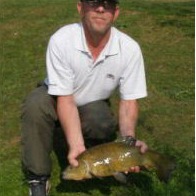

In [ ]:
rgb(image, cl=0)

<matplotlib.image.AxesImage>

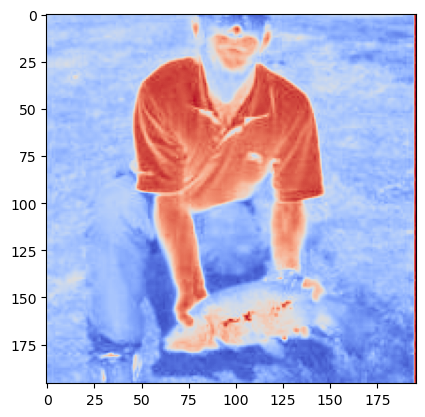

In [ ]:
# |hide
plt.imshow(image[0], cmap="coolwarm") # One single channel.

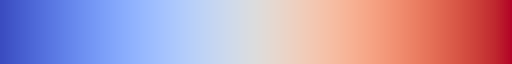

In [ ]:
# |hide
cmap = get_cmap("coolwarm"); cmap

In [ ]:
# |hide
cmap(0), cmap(0.5), cmap(1) # Maps float [0, 1] -> RGBA values. Works on np arrays.

((0.2298057, 0.298717966, 0.753683153, 1.0),
 (0.8674276350862745, 0.864376599772549, 0.8626024620196079, 1.0),
 (0.23437707945098038, 0.3055417303294118, 0.7596795275882353, 1.0))

In [ ]:
# |hide
# cmap has a lookup table with the structure:
#  0 ... 255 -> RGBA values for [0 , 1]
#        256 -> RGBA for below min
#        257 -> RGBA for above max
#        258 -> RGBA for NaN
lovely(cmap._lut)

ndarray[259, 4] n=1036 x∈[0., 1.000] μ=0.755 σ=0.258

ndarray[196, 196, 4] n=153664 x∈[0.033, 1.000] μ=0.796 σ=0.220


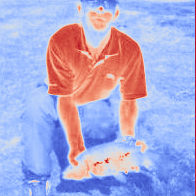

In [ ]:
# |hide
# Same, but use tensors
lut = cmap._lut.copy()

# Converts values between 0..1 to integers betwen 0 and 255.
lut_idxs = (image[0] * 255).astype(np.uint8).astype(np.int64)

# Use F.embedding as a table lookup 
mapped = lut.take(lut_idxs, axis=0)
# embedding(lut_idxs, tensor_cmap)

print(lovely(mapped))
rgb(mapped, cl=1) # imshow is fine with channel-last RGBA.

In [ ]:
# |hide
# This works for tensors with arbitraty dimensions
# The RGBA is always slapped on as the last dimension.

image_batch = image[None].repeat(10, axis=0)
print(lovely(image_batch))

lut_idxs = (image_batch * 255).astype(np.uint8).astype(np.int64)
mapped = lut.take(lut_idxs, axis=0)

print(lovely(mapped))

ndarray[10, 3, 196, 196] n=1152480 x∈[-4.053e-09, 1.000] μ=0.361 σ=0.248
ndarray[10, 3, 196, 196, 4] n=4609920 x∈[0.016, 1.000] μ=0.775 σ=0.235


ndarray[196, 196, 4] n=153664 x∈[0., 1.000] μ=0.775 σ=0.261


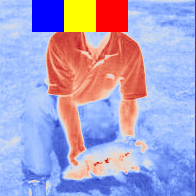

In [ ]:
# |hide
# Handle clipping and NaNs.
lut = cmap._lut.copy()

bad_image = image.copy()

bad_image[0,0:32,32:64] = -0.1 # Below min
bad_image[0,0:32,64:96] = float("nan")
bad_image[0,0:32,96:128] = 1.1 # Above max

lut[256] = np.array([0., 0, 1, 1]) # Blue for below min
lut[257] = np.array([1., 0, 0, 1]) # Red for above max
lut[258] = np.array([1., 1, 0, 1]) # Yellow for NaNs

lut_idxs = (bad_image * 255).astype(np.uint8).astype(np.int64)
lut_idxs[ bad_image < 0. ] = 256
lut_idxs[ bad_image > 1. ] = 257
lut_idxs[ np.isnan(bad_image)] = 258

# Use F.embedding as a table lookup mechanism

mapped = lut.take(lut_idxs, axis=0)

# mapped = embedding(lut_idxs, tensor_cmap)

print(lovely(mapped[0]))
rgb(mapped[0])

In [ ]:
# |hide
# Let's extend the lut to cover +/-inf too.

tensor_cmap_ninf = np.array([[0, 1, 1, 1]]) # Cyan for -inf
tensor_cmap_pinf = np.array([[1, 0, 1, 1]]) # Fuchsia for +inf

# Add mapping for -inf at positoin 259 and +inf at 260
lut = np.concatenate([
    lut,
    tensor_cmap_ninf,
    tensor_cmap_pinf])

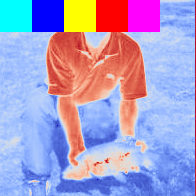

In [ ]:
# |hide
bad_image[0,0:32,0:32] = float("-inf")
bad_image[0,0:32,128:128+32] = float("+inf")

lut_idxs[ np.isneginf(bad_image) ] = 259
lut_idxs[ np.isposinf(bad_image) ] = 260

mapped = lut.take(lut_idxs, axis=0)

# mapped = embedding(lut_idxs, tensor_cmap)
rgb(mapped[0])

# mapped[0].rgb(cl=1)

In [ ]:
# |export

class InfCmap():
    """
    Matplotlib colormap extended to have colors for +/-inf

    Parameters extept `cmap` are matplotlib color strings.
    """
    def __init__(self,
                 cmap:  Colormap, # Base matplotlib colormap
                 below: Optional[str] =None, # Values below 0
                 above: Optional[str] =None, # Values above 1
                 nan:   Optional[str] =None, # NaNs
                 ninf:  Optional[str] =None, # -inf
                 pinf:  Optional[str] =None, # +inf
                ):
        _ = cmap(0) # one call to make sure the cmap is initialized
        assert len(cmap._lut) == 259, "The colormap LUT should have 259 inputs"
        lut = cmap._lut.copy()
        
        if below: lut[256] = np.array(to_rgba(below))
        if above: lut[257] = np.array(to_rgba(above))
        if nan: lut[258] = np.array(to_rgba(nan))

        # For +/- inf, use above/below as defaults.
        tensor_cmap_ninf = np.array(to_rgba(ninf)) if ninf else lut[256]
        tensor_cmap_pinf = np.array(to_rgba(pinf)) if pinf else lut[257]

        # Remove the alpha channel, it causes probems in pad_frame_gutters().
        self.lut = np.concatenate([ lut, tensor_cmap_ninf[None], tensor_cmap_pinf[None] ])[:,:3]

    def __call__(self, t: np.ndarray):
        lut_idxs = (t*255).astype(np.uint8).astype(np.int64)
        
        lut_idxs[ t < 0. ] = 256
        lut_idxs[ t > 1. ] = 257
        lut_idxs[ np.isnan(t)] = 258

        lut_idxs[ np.isneginf(t) ] = 259
        lut_idxs[ np.isposinf(t) ] = 260
        
        return self.lut.take(lut_idxs, axis=0) # RGB added as color-last.
        
         

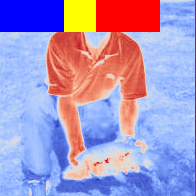

In [ ]:
tcmap = InfCmap(get_cmap("coolwarm"),
                  below="blue", above="red", nan="yellow")
rgb(tcmap(bad_image[0])) # Note: Mapped only first channel

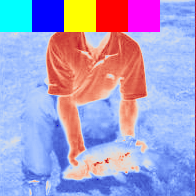

In [ ]:
tcmap = InfCmap(get_cmap("coolwarm"),
                  below="blue", above="red",
                  nan="yellow", ninf="cyan", pinf="fuchsia")
rgb(tcmap(bad_image)[0]) # Note: Mapped all channels, show only the mapping for the first.

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()